In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# grab the advertising and credit datasets and use specified columns
# Advertising Data
advertising_data = pd.read_csv('Data/Advertising.csv',usecols=[1,2,3,4])

# Credit Data
credit_data = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
# remap values of student column to binary
credit_data['Student2'] = credit_data.Student.map({'No':0, 'Yes':1})

# Auto data
auto_data = pd.read_csv('Data/Auto.csv', na_values='?').dropna()

In [3]:
advertising_data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
credit_data.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,0
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0


In [5]:
auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


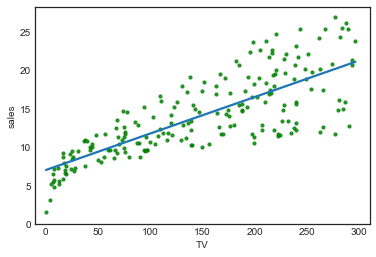

In [6]:
# fit a line to the data
sns.regplot(advertising_data.TV,
            advertising_data.sales,
            order=1,
            ci=None,
            scatter_kws={'color':'g', 's':10}
            )
# set axis lmits
plt.xlim(-10,310)
plt.ylim(ymin=0);